In [1]:
import os
import tifffile
import rasterio

import cv2
import numpy as np

import leafmap.leafmap as leafmap
from samgeo import SamGeo2

import geopandas as gpd
import pickle
from pyproj import Transformer

from utils.tools import get_raster_data, read_geojson, save_raster_and_write_meta
from utils.mask_tools import Mask_profile
import matplotlib.pyplot as plt


## A. Getting a satellite image and export it to a GeoTiff file

In [ ]:
m = leafmap.Map(center=[12.94316, 101.001263], zoom=16, height="800px")
m.add_basemap("Satellite")
m

In [ ]:
if m.user_roi is not None:
    bbox = m.user_roi_bounds()
    coordinates = m.user_rois['features'][0]['geometry']['coordinates'][0]
else:
    bbox = [100.9230026816609, 13.054297390119896, 100.9261026816609, 13.052397390099848] 
    coordinates = [
        [bbox[0], bbox[3]],  # Top-left corner (min_lon, max_lat)
        [bbox[2], bbox[3]],  # Top-right corner (max_lon, max_lat)
        [bbox[2], bbox[1]],  # Bottom-right corner (max_lon, min_lat)
        [bbox[0], bbox[1]],  # Bottom-left corner (min_lon, min_lat)
        [bbox[0], bbox[3]]   # Closing the polygon by repeating the first point
        ]

In [ ]:
clipped_satellite_file = "examples/clipped_satellite.tif"  

leafmap.map_tiles_to_geotiff(
    output=clipped_satellite_file, bbox=bbox, zoom=18, source="Satellite", overwrite=True
)

In [ ]:
selected_coordinates = {} 
selected_coordinates["bbox"] = bbox
selected_coordinates["coordinates"] = coordinates
 

file_path = 'examples/selected_coordinates.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(selected_coordinates, file)

In [ ]:
clipped_image_file = "examples/clipped_image.tif"
clipped_satellite_file = "examples/clipped_satellite.tif"

## B. Using GeoSam2 to detect masks in a satellite image

In [ ]:
sam = SamGeo2(
    model_id="sam2-hiera-large",
    automatic=False,
    device="cuda"
)

In [ ]:
sam_input_image = clipped_satellite_file
# sam_input_image = clipped_image_file

In [ ]:
sam.set_image(sam_input_image)
sam.show_map()

## C. View masks and detected objects

In [ ]:
# raster files
clipped_image_file = "examples/clipped_image.tif" 
clipped_satellite_file = "examples/clipped_satellite.tif"

# from SamGeo2
center_geojson  = "sam_output/masks_new_fg_markers.geojson" 
extracted_masks = "sam_output/masks_new.tif"
gpkg_path       = "sam_output/masks_new_rect.gpkg"

In [3]:
m = leafmap.Map()
m.add_raster(clipped_satellite_file, layer_name="Image")
m.add_raster(clipped_image_file, layer_name="Theos")
m.add_circle_markers_from_xy(center_geojson, radius=3, color="red", fill_color="yellow", fill_opacity=0.8)

m.add_raster(extracted_masks, cmap="jet", nodata=0, opacity=0.7, layer_name="Building masks")
m.add_vector(gpkg_path, layer_name="Rect")
m

Map(center=[13.053346999999999, 100.924553], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

## D. Making the bounding boxes

In [4]:
extracted_masks = "sam_output/masks_new.tif"

In [5]:
mask, tif_data = get_raster_data(extracted_masks)

Dataset name: sam_output/masks_new.tif
File mode: r
Number of bands: 1
Image width: 578 pixels
Image height: 364 pixels
Coordinate Reference System (CRS): EPSG:3857
Data shape: (1, 364, 578)
Data type: int32


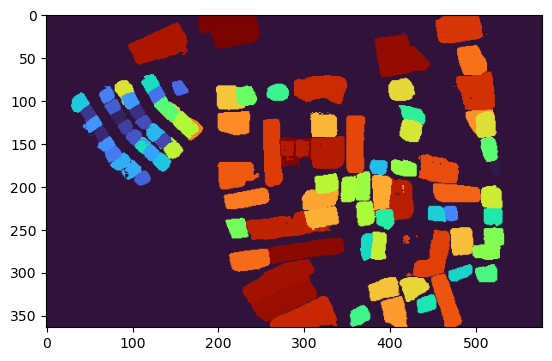

In [6]:
# In order to view those masks, we need to convert it to uint8 datatype.
mask_uint8 = mask.astype(np.uint8)
plt.imshow(mask_uint8[0,:,:], cmap='turbo')

In [7]:
center_geojson  = "sam_output/masks_new_fg_markers.geojson"
Mask_obj        = Mask_profile(extracted_masks, center_geojson_file=center_geojson, center_geojson_crs="EPSG:4326") 

Dataset name: sam_output/masks_new.tif
File mode: r
Number of bands: 1
Image width: 578 pixels
Image height: 364 pixels
Coordinate Reference System (CRS): EPSG:3857
Data shape: (1, 364, 578)
Data type: int32


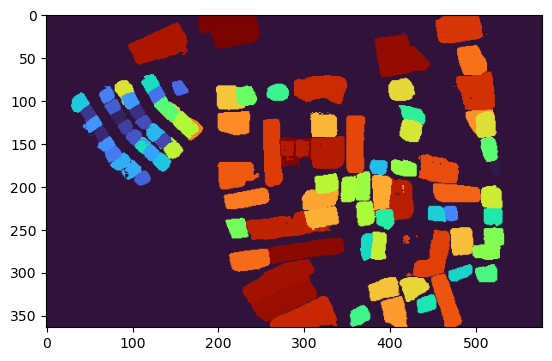

In [8]:
plt.imshow(Mask_obj.mask.astype(np.uint8), cmap='turbo')

In [ ]:
gdf = Mask_obj.make_boundboxes()
gdf.to_file("examples/boundbox.geojson", driver='GeoJSON')  

In [ ]:
m = leafmap.Map()
m.add_raster(clipped_satellite_file, layer_name="Image")
m.add_raster(clipped_image_file, layer_name="Theos")
m.add_circle_markers_from_xy(center_geojson, radius=3, color="red", fill_color="yellow", fill_opacity=0.8)
m.add_raster(extracted_masks, cmap="jet", nodata=0, opacity=0.7, layer_name="Building masks")
m.add_vector("examples/boundbox.geojson", layer_name="Bounding Boxes")
m

Map(center=[13.053346999999999, 100.924553], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

## F. Improving the masks

Dataset name: clipped_satellite.tif
File mode: r
Number of bands: 3
Image width: 578 pixels
Image height: 364 pixels
Coordinate Reference System (CRS): EPSG:3857
Data shape: (3, 364, 578)
Data type: uint8


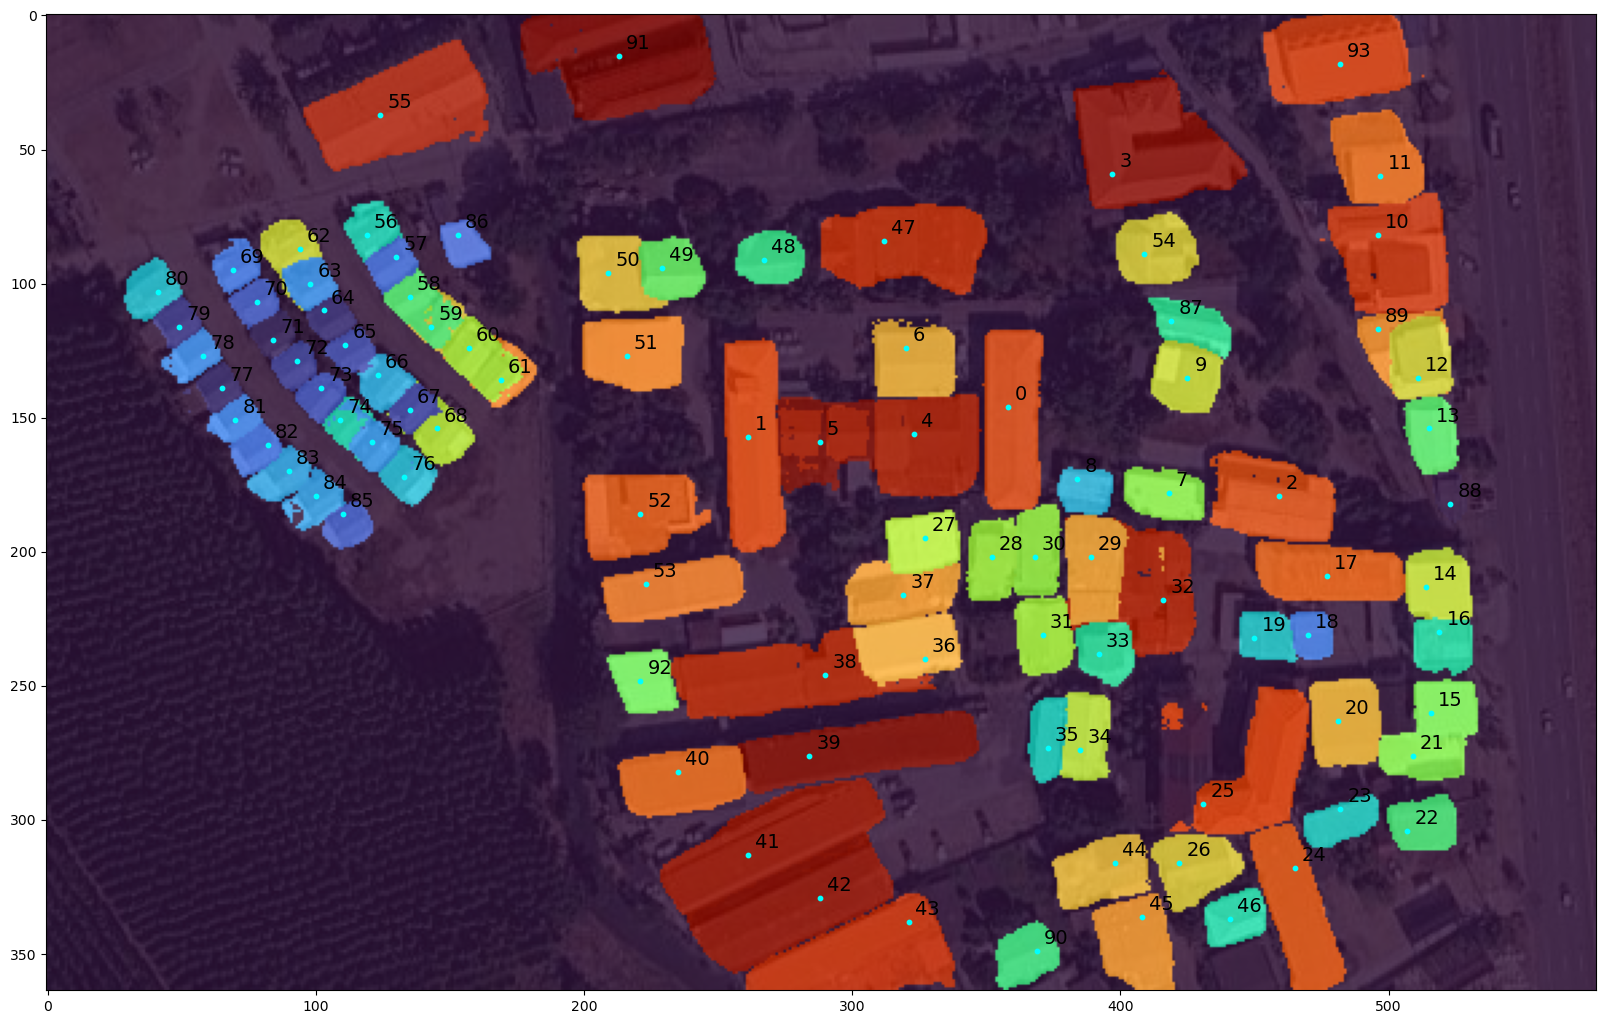

In [11]:
sat_image, _ = get_raster_data(clipped_satellite_file)
Mask_obj.show_mask_order(figsize=(20, 15), fontsize=14, alpha=0.8, satellite_image=sat_image)


### Choose the (manual) index to be corrected 

In [12]:
manual_index = 25

Dataset name: clipped_satellite.tif
File mode: r
Number of bands: 3
Image width: 578 pixels
Image height: 364 pixels
Coordinate Reference System (CRS): EPSG:3857
Data shape: (3, 364, 578)
Data type: uint8


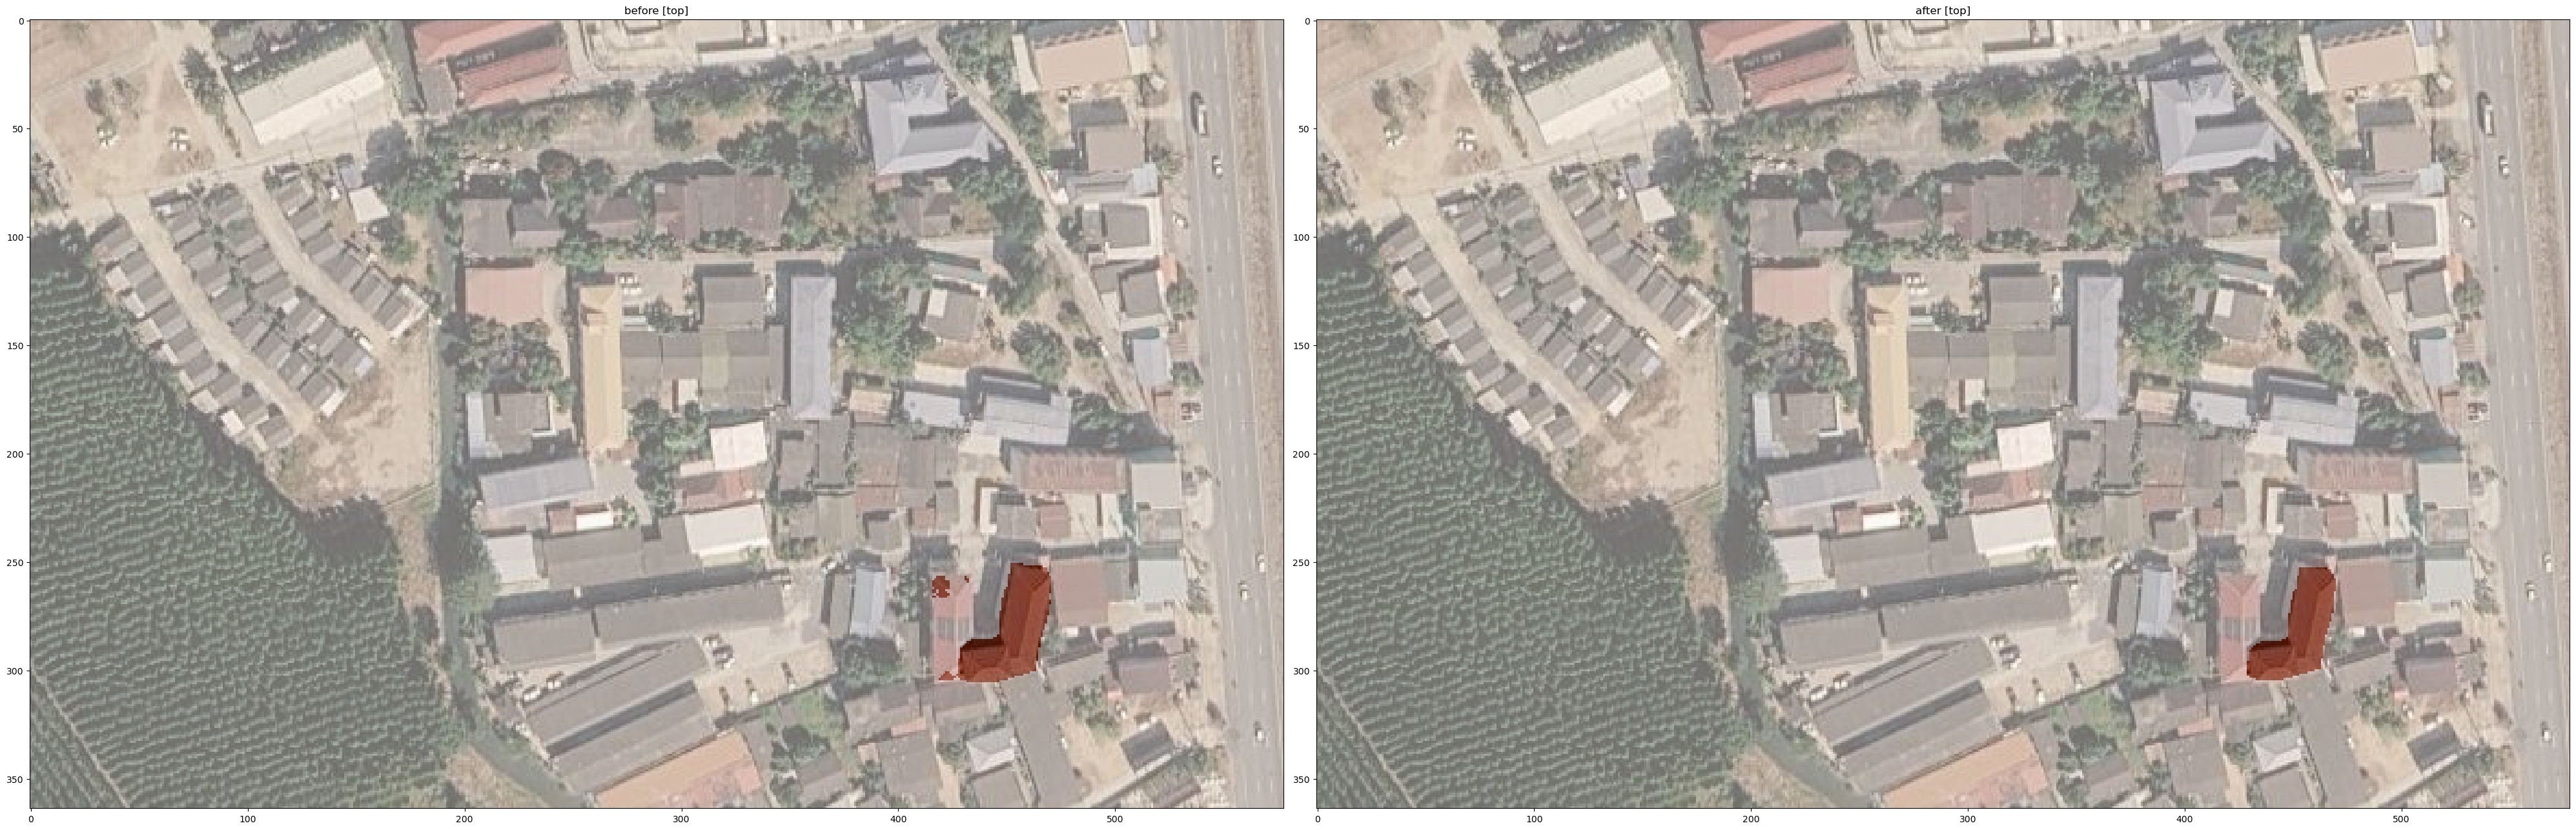

In [13]:
sat_image, _ = get_raster_data(clipped_satellite_file)
gray_bf = Mask_obj.get_a_binary_mask(manual_index)

sat_image = sat_image.transpose(1,2,0)

record_af_list = []
gray_af, record_af = Mask_obj.filling_holes(1*gray_bf)
record_af_list.append(record_af)
gray_af, record_af = Mask_obj.erosion(gray_af.astype(np.uint8), kernel_size=7)
record_af_list.append(record_af)
gray_af, record_af = Mask_obj.dilation(gray_af.astype(np.uint8), kernel_size=5)
record_af_list.append(record_af)


fig, axs = plt.subplots(1, 2, figsize=(40, 30))

axs[0].imshow(sat_image)
axs[0].imshow(gray_bf, cmap='Oranges', alpha=0.45)
axs[0].set_title("before [top]")
 

axs[1].imshow(sat_image)
axs[1].imshow(gray_af, cmap='Oranges', alpha=0.45)
axs[1].set_title("after [top]")
 

plt.tight_layout()

#### Update the result

Text(0.5, 1.0, 'after')

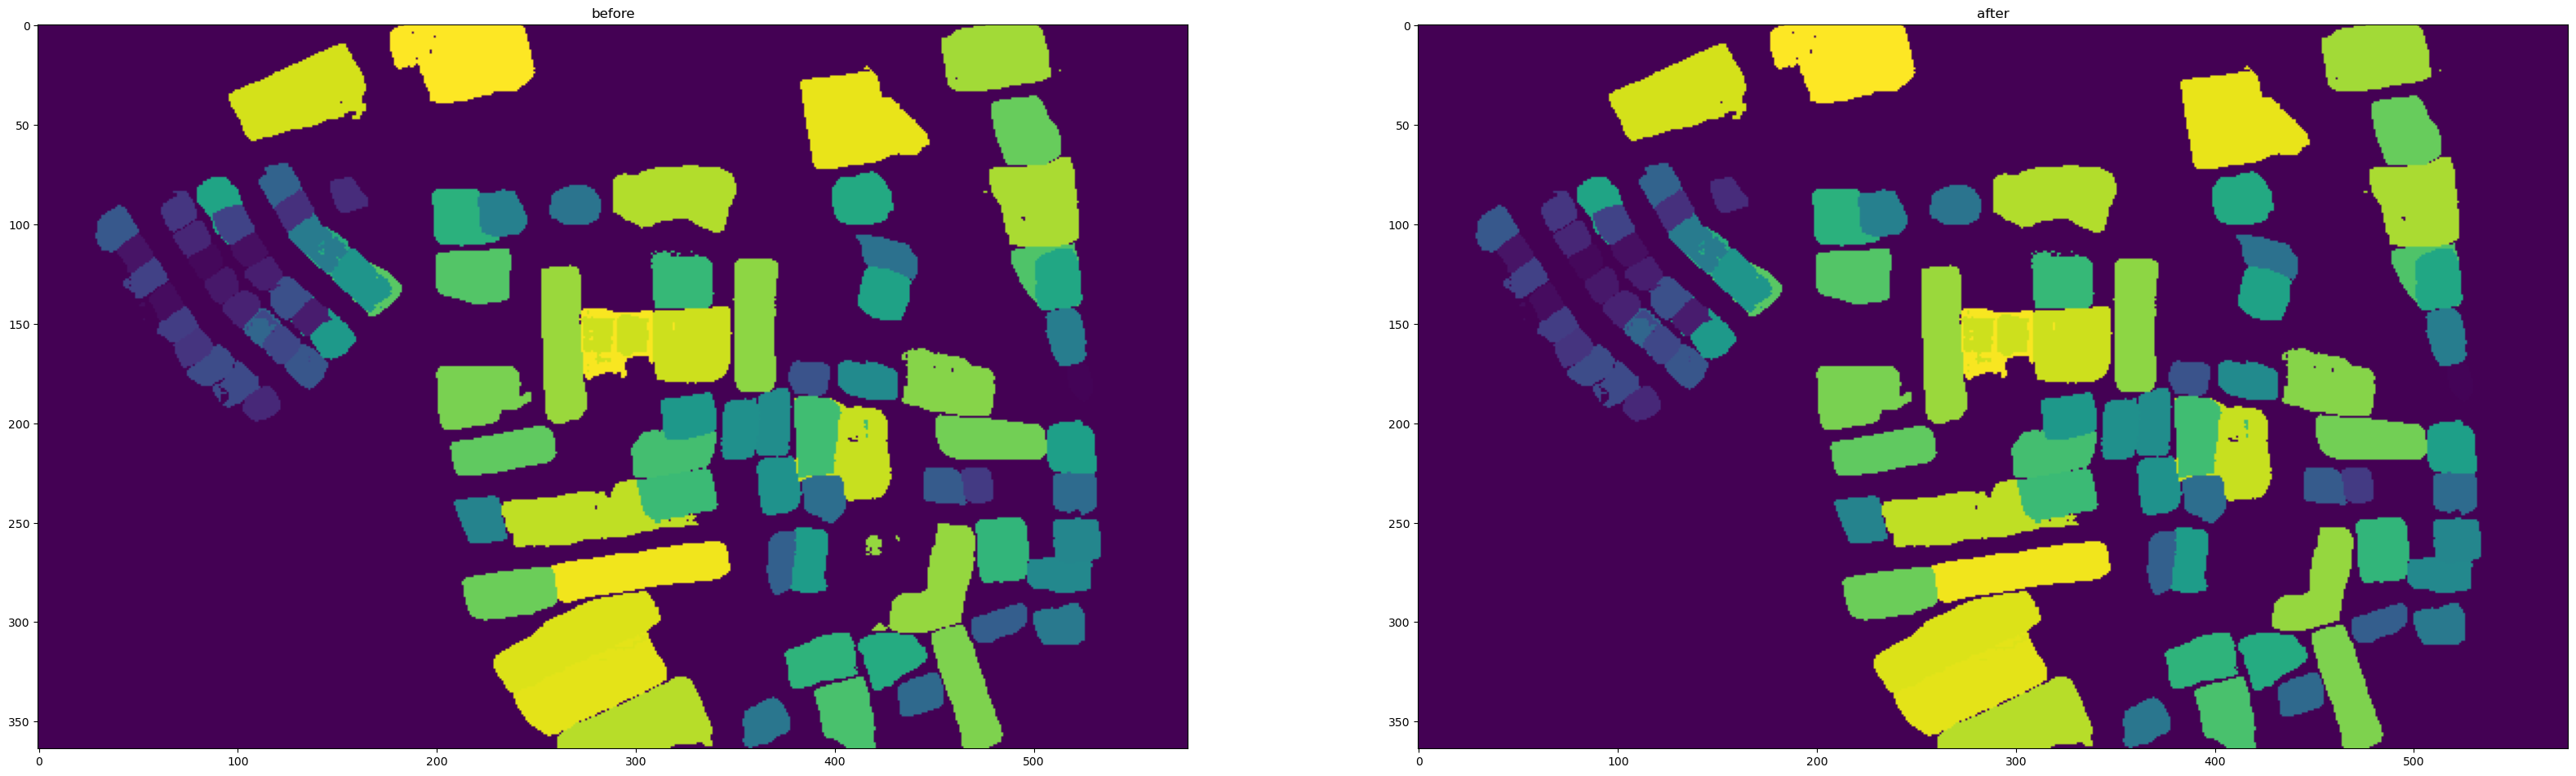

In [14]:
mask_2D = Mask_obj.update_a_binary_mask(gray_af, manual_index, record_af_list) 

fig, axs = plt.subplots(1, 2, figsize=(40, 15))

axs[0].imshow(sat_image)
axs[0].imshow(mask[0, :, :])
axs[0].set_title("before")

axs[1].imshow(sat_image)
axs[1].imshow(mask_2D[0, :, :])
axs[1].set_title("after")
 

In [15]:
Mask_obj.record_list

[{'gjcenter_id': 25, 'Operation': 'filling_holes', 'Kernel': None},
 {'gjcenter_id': 25, 'Operation': 'erosion', 'Kernel': 7},
 {'gjcenter_id': 25, 'Operation': 'dilation', 'Kernel': 5}]

In [16]:
destination_tif = "sam_output/masks_new_edited.tif"
meta_source_tif = "sam_output/masks_new.tif"
save_raster_and_write_meta(mask_2D, destination_tif, meta_source_tif)

Modified image saved to : sam_output/masks_new_edited.tif


Text(0.5, 1.0, 'after')

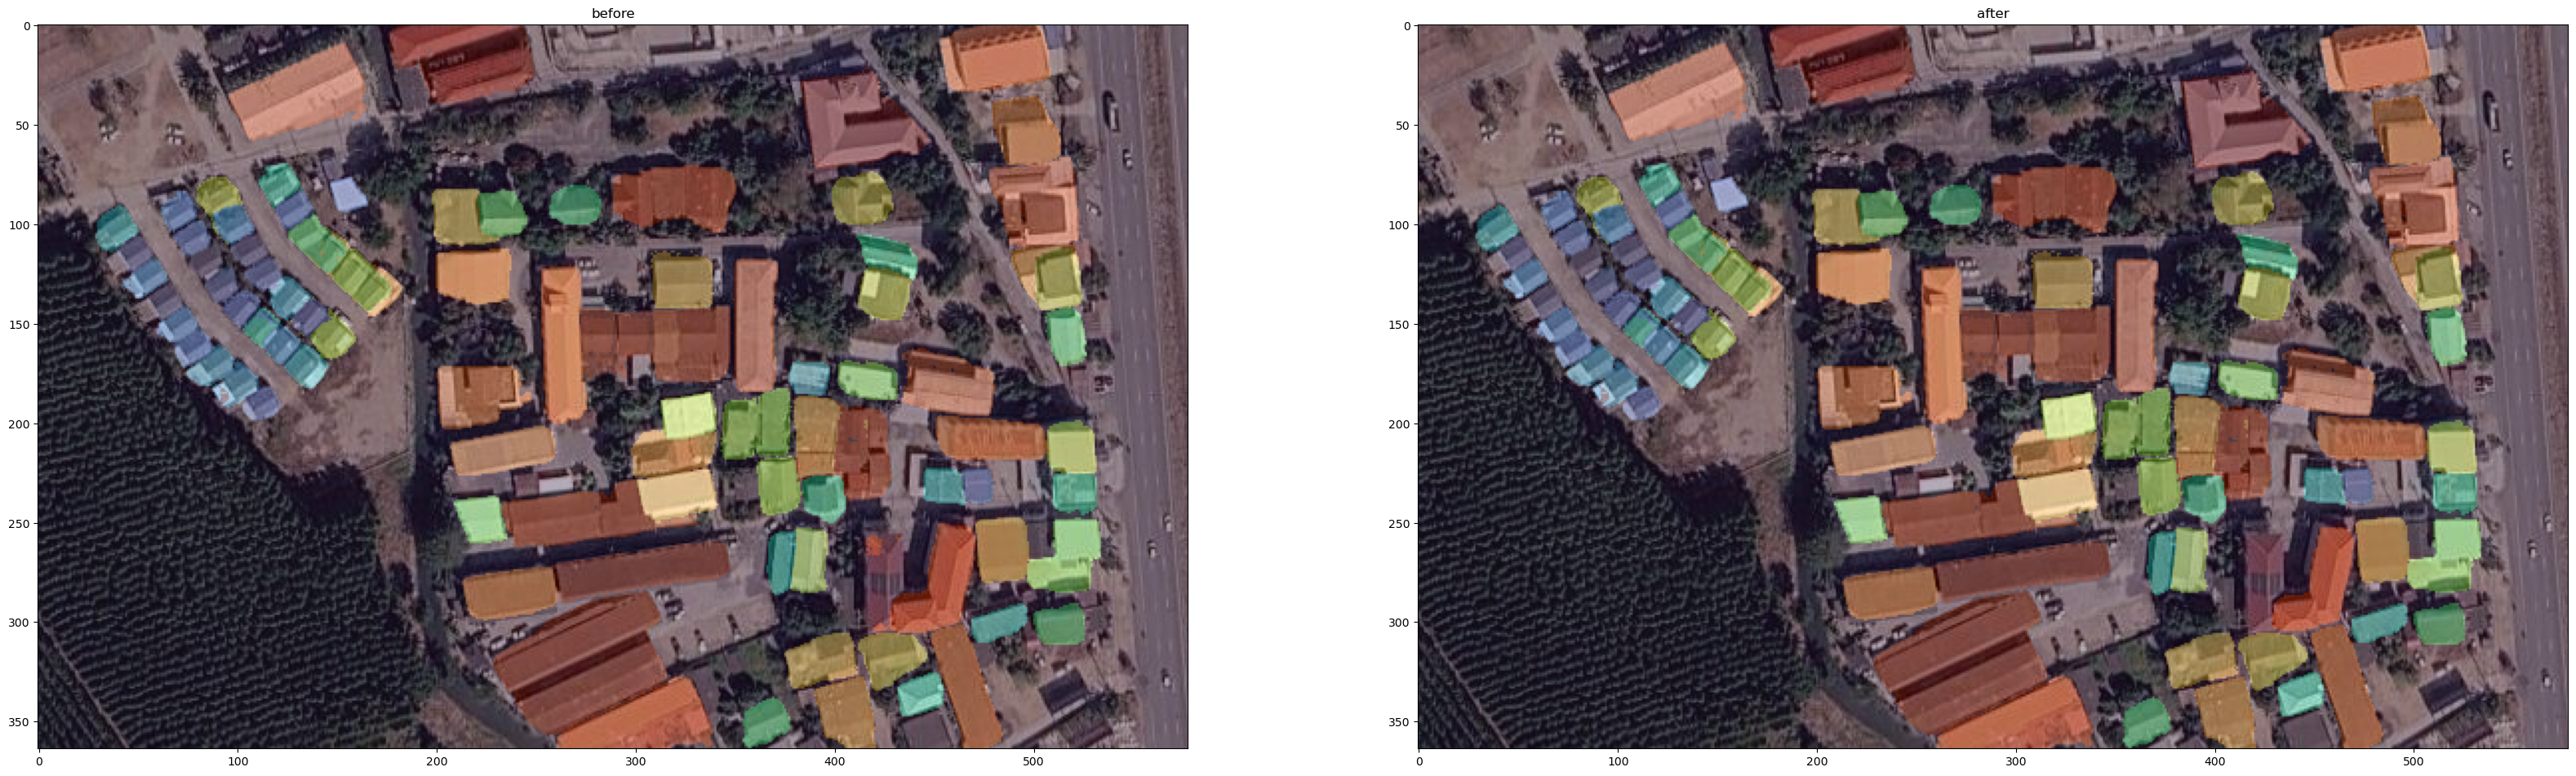

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(40, 30))
 
axs[0].imshow(sat_image)
axs[0].imshow(mask_uint8[0,:,:], cmap='turbo', alpha=0.35) 
axs[0].set_title("before")

axs[1].imshow(sat_image)
axs[1].imshow(mask_2D[0,:,:], cmap='turbo', alpha=0.35) 
axs[1].set_title("after")

#### Check if it can be used as a map

In [18]:
m = leafmap.Map()
m.add_raster(clipped_satellite_file, layer_name="Image") 
m.add_circle_markers_from_xy(center_geojson, radius=3, color="red", fill_color="yellow", fill_opacity=0.8
) 
m.add_raster(extracted_masks, cmap="jet", layer_name="Building masks (before)") 
m.add_raster(destination_tif, cmap="jet", layer_name="Building masks (after)") 
m

Map(center=[13.053346999999999, 100.924553], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…